# Analysis of Parameter Estimation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tellurium as te  
import json


### Load all data relevant for analysis

In [19]:
pth_model = te.loada('LCT_model/LCT_OIE.ant')
non_pth_model = te.loada('LCT_model/LCT_OIE.ant')

data = pd.read_csv('datasets/OIE_data.csv')

fit_data_pth = pd.read_csv('Estimation/pth.csv')
with open('Estimation/pth/2023_11_24_12_05_1.json', 'r') as f:
  pth_result = json.load(f)

fit_data_non_pth = pd.read_csv('Estimation/non_pth.csv')
with open('Estimation/non_pth/2023_11_24_12_05_1.json', 'r') as f:
  non_pth_result = json.load(f)


In [20]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death', 'k_E_death'] + [f'[oiE_{i}]' for i in range(1, 13)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    pth_model.setValue(p, pth_result['update_parameters'][p])

pre_t = pth_result['best_parameters']['pre_t']
pth_res = pth_model.simulate(-pre_t, 200, 100, selections=species_selct)
pth_res_df = pd.DataFrame(pth_res, columns=pth_res.colnames) 

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    non_pth_model.setValue(p, non_pth_result['update_parameters'][p])

pre_t = non_pth_result['best_parameters']['pre_t']
non_pth_res = non_pth_model.simulate(-pre_t, 200, 100, selections=species_selct)
non_pth_res_df = pd.DataFrame(non_pth_res, columns=non_pth_res.colnames) 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

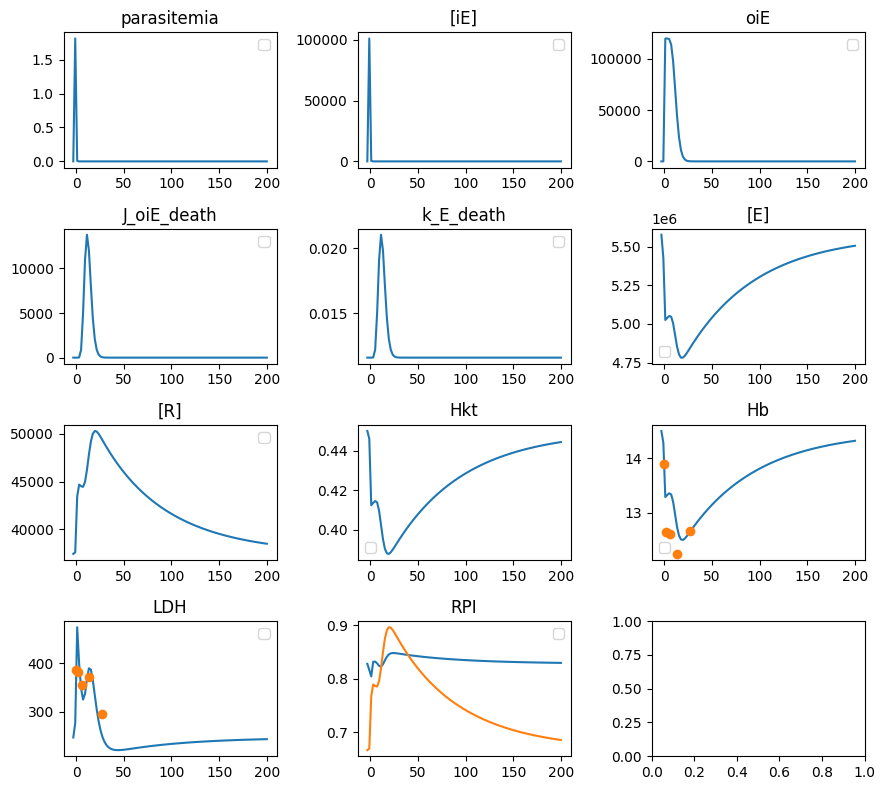

In [24]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI']

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(pth_res_df['time'], pth_res_df[obs])

    ax[row, col].set_title(obs)
    ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')

rpi_calc = (pth_res_df['[R]'] / (pth_res_df['[R]'] + pth_res_df['[E]']+pth_res_df['[iE]'] + pth_res_df['oiE'])) * 100 * pth_res_df['Hkt'] / 0.45
ax[3, 1].plot(pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

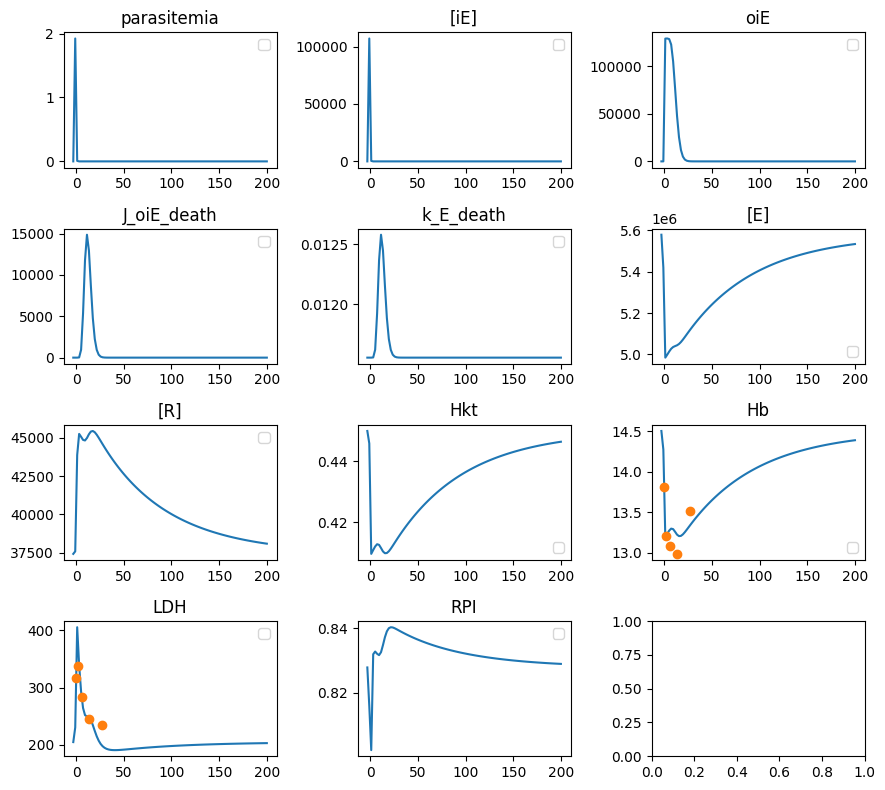

In [22]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI']

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs])

    ax[row, col].set_title(obs)
    ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
plt.tight_layout()  
plt.show()
